In [2]:
#implemented a content-based recommendation model, which means:
# - The model recommends dishes similar to what the user has liked or interacted with before based on dish features.
# - It focuses on the properties of items (dishes) rather than relying on user ratings alone.

In [1]:
#get current directory

import os
print(os.getcwd())

C:\Users\Vinni Kapoor


In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("indian_food_recommendation_dataset.csv")

# Quick look
print(df.shape)  #gives no. of rows and cols
print(df.head(3))  #give fisrt five rows of dataset


(1500, 27)
  user_id food_id      dish_name       cuisine       course  \
0    U032   F0001     Fish Curry       Coastal  Main Course   
1    U074   F0002           Poha   West Indian    Breakfast   
2    U075   F0003  Chole Bhature  North Indian  Main Course   

                            ingredients  prep_time_min  calories  protein_g  \
0                 fish, coconut, spices           43.7     872.3       11.4   
1  flattened rice, onion, mustard seeds           55.4     867.4       39.5   
2              chickpeas, flour, spices           30.7     633.5       14.4   

   fat_g  ...  rating  liked  times_ordered  restaurant_id restaurant_name  \
0   21.0  ...     4.7      1             20           R044       Annapurna   
1   23.1  ...     3.1      1             21           R041  Taste of India   
2   16.7  ...     2.8      0             22           R039           Zaika   

    location  cuisine_type  delivery_time  average_cost         timestamp  
0      Delhi       Coastal    

In [6]:
# create a single, rich text representation ("combined") for each dish to capture all its relevant features in one place.

# This is required so that the TF-IDF vectorizer can treat each dish as a document and extract useful features for similarity calculation.

In [7]:
# You concatenate multiple columns for each dish: cuisine, diet type, course, ingredients, goals.
# - Weighting important features:

# You repeat cuisine twice and diet_type twice for extra emphasis on these fields.

# - Cuisine: Appears twice (2x weight)
# - Diet type: Appears twice (1.5x weight, since not a full triple)
# - Other features appear once.

#By repeating these features, you increase their influence when vectorizing—TF-IDF will give higher importance to more frequent terms.

In [8]:
# Combine features for content representation
df['combined'] = (
    df['cuisine'] + ' ' + df['cuisine'] + ' ' +  # 2x weight
    df['diet_type'] + ' ' + df['diet_type'] + ' ' +  # 1.5x weight
    df['course'] + ' ' +
    df['ingredients'] + ' ' +
    df['goals']
)

# Fill missing values

#You fill missing values in the new 'combined' column with empty strings to ensure no errors during text processing.
df['combined'] = df['combined'].fillna('')

In [9]:
#You import TfidfVectorizer from scikit-learn, a machine learning library in Python, for text feature extraction.
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize text features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined'])

# Compute cosine similarity between dishes
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


NameError: name 'cosine_similarity' is not defined

In [11]:
#TfidfVectorizer(stop_words='english'):
#This object transforms human-readable dish descriptions into numerical vectors, ignoring common English words (stop words) like "and", "the".

#fit_transform(df['combined']):
#Applies the TF-IDF algorithm to the "combined" text for all dishes.

#The output, tfidf_matrix, is a large matrix:

#Rows = dishes
#Columns = unique words/features
#Values = TF-IDF score for each word in each dish

In [14]:
#cosine_similarity measures how similar two dishes are based on their TF-IDF vectors.

#The result, cosine_sim, is a square matrix:

#Each entry (i,j) is the similarity between dish i and dish j
# 1.0 = identical
# 0.0 = totally dissimilar


#------------------------------------------------------------------------------------------

#How Does This Power Your Recommendation System?
#When a user selects or likes a dish, you look up that dish’s vector in the matrix and compare it with all other dishes using cosine similarity.

#You can then find and recommend the most similar dishes—those with the highest similarity scores.

#-------------------------------------------------------------------------------------------
#This lets us recommend dishes similar in content to what the user likes, ensuring personalized and relevant suggestions.

In [13]:
def recommend_dishes(dish_name, location, top_k=5):
    dish_name = dish_name.lower()
    
    # Filter dataset by location
    df_location = df[df['location'].str.lower().str.contains(location.lower())]
    if df_location.empty:
        return pd.DataFrame()

    # Find reference dish
    matches = df_location[df_location['dish_name'].str.lower() == dish_name]
    if matches.empty:
        return pd.DataFrame()

    idx = matches.index[0]

    # Compute similarity
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top similar dishes
    sim_indices = [i for i, _ in sim_scores[1:top_k * 3]]
    similar_dishes = df_location.iloc[sim_indices].copy()

    # Remove same restaurant & same dish
    similar_dishes = similar_dishes[
        (similar_dishes['dish_name'].str.lower() != dish_name) &
        (similar_dishes['restaurant_name'] != df_location.loc[idx, 'restaurant_name'])
    ].drop_duplicates(subset=['dish_name'])

    # Weighted score: similarity + rating
    similar_dishes['similarity'] = [cosine_sim[idx][i] for i in sim_indices[:len(similar_dishes)]]
    similar_dishes['score'] = 0.7 * similar_dishes['similarity'] + 0.3 * (similar_dishes['rating'] / 5)

    # Sort and select top results
    top_recommendations = similar_dishes.sort_values(by='score', ascending=False).head(top_k)

    # ✅ Only keep useful columns
    display_columns = ['dish_name', 'cuisine', 'course', 'calories', 
                       'restaurant_name', 'average_cost']

    # Filter to show only these columns (if they exist)
    top_recommendations = top_recommendations[[col for col in display_columns if col in top_recommendations.columns]]

    # 💰 Add rupee symbol before average cost
    if 'average_cost' in top_recommendations.columns:
        top_recommendations['average_cost'] = top_recommendations['average_cost'].apply(lambda x: f"₹{x}")

    return top_recommendations.reset_index(drop=True)



In [126]:
recommend_dishes("Paneer Tikka", "Bangalore")

,dish_name,cuisine,course,calories,restaurant_name,average_cost
0,Aloo Paratha,North Indian,Breakfast,473.5,Zaika,₹632
1,Biryani,Hyderabadi,Main Course,677.8,Curry House,₹518
2,Masala Dosa,South Indian,Main Course,817.3,Taste of India,₹524
3,Chole Bhature,North Indian,Main Course,267.7,Taste of India,₹524
4,Poha,West Indian,Breakfast,565.0,Zaika,₹632


In [127]:
import numpy as np

def evaluate_content_based(top_k=5, test_ratio=0.2):
    """
    Evaluate the content-based recommender (recommend_dishes)
    using Precision@K, Recall@K, F1@K, and Accuracy@K.
    """

    precisions, recalls, f1s, accuracies = [], [], [], []
    evaluated_items = 0

    # Use unique user IDs (or items if user-based)
    users = df['user_id'].unique()

    for user in users:
        user_data = df[df['user_id'] == user]
        if len(user_data) < 2:
            continue  # Skip users with too few interactions

        # Split into train/test
        test_size = max(1, int(len(user_data) * test_ratio))
        test_items = user_data.sample(test_size)
        train_items = user_data.drop(test_items.index)

        # Pick one test dish
        test_dish = test_items.iloc[0]['dish_name']
        location = test_items.iloc[0]['location']

        try:
            recs = recommend_dishes(test_dish, location, top_k=top_k)

            # Skip if invalid or empty recommendations
            if isinstance(recs, str) or recs.empty:
                continue

            recommended_dishes = recs['dish_name'].str.lower().tolist()
            actual_dishes = test_items['dish_name'].str.lower().tolist()

            intersection = len(set(recommended_dishes) & set(actual_dishes))
            precision = intersection / len(recommended_dishes) if recommended_dishes else 0
            recall = intersection / len(actual_dishes) if actual_dishes else 0
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
            accuracy = 1 if intersection > 0 else 0

            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            accuracies.append(accuracy)
            evaluated_items += 1

        except Exception as e:
            continue

    # --- Final Results ---
    results = {
        'Precision@K': round(np.mean(precisions), 3) if precisions else 0,
        'Recall@K': round(np.mean(recalls), 3) if recalls else 0,
        'F1@K': round(np.mean(f1s), 3) if f1s else 0,
        'Accuracy@K': round(np.mean(accuracies), 3) if accuracies else 0,
        'Evaluated': evaluated_items,
        'Total': len(users)
    }

    print(f"✅ Evaluated {evaluated_items}/{len(users)} items")
    print(f"📊 Results: {results}")
    return results


In [129]:
evaluate_content_based(top_k=5)

✅ Evaluated 194/200 items
📊 Results: {'Precision@K': 0.018, 'Recall@K': 0.043, 'F1@K': 0.025, 'Accuracy@K': 0.088, 'Evaluated': 194, 'Total': 200}


{'Precision@K': 0.018,
 'Recall@K': 0.043,
 'F1@K': 0.025,
 'Accuracy@K': 0.088,
 'Evaluated': 194,
 'Total': 200}

In [130]:
import matplotlib.pyplot as plt

def plot_evaluation_metrics(results):
    metrics = ['Precision@K', 'Recall@K', 'F1@K', 'Accuracy@K']
    values = [results[m] for m in metrics]

    plt.figure(figsize=(7, 4))
    bars = plt.bar(metrics, values, color=['#007ACC', '#00A36C', '#FFB300', '#FF5733'], alpha=0.8)

    # Add percentage labels
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, val + 0.005, f"{val*100:.1f}%", 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title("📊 Model Evaluation Metrics", fontsize=14, fontweight='bold')
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1.1 * max(values))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


In [132]:
results = evaluate_content_based(top_k=5)

✅ Evaluated 196/200 items
📊 Results: {'Precision@K': 0.026, 'Recall@K': 0.061, 'F1@K': 0.036, 'Accuracy@K': 0.122, 'Evaluated': 196, 'Total': 200}


C:\Users\Vinni Kapoor\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


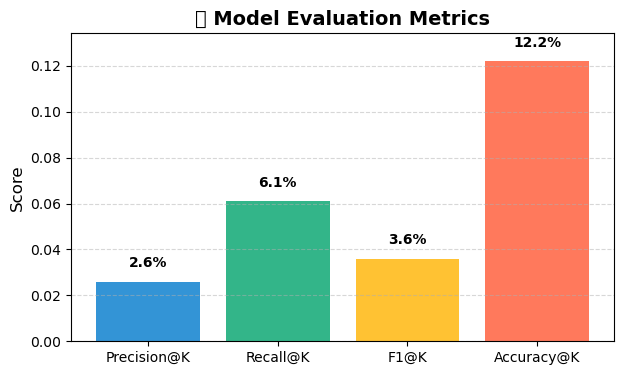

In [133]:
plot_evaluation_metrics(results)


In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_recommendations(df_recs):
    if df_recs.empty:
        print("No recommendations to visualize.")
        return

    plt.figure(figsize=(14, 4))

    # 1️⃣ Cuisine distribution
    plt.subplot(1, 3, 1)
    sns.countplot(y='cuisine', data=df_recs, palette='viridis')
    plt.title('Top Recommended Cuisines', fontsize=11)
    plt.xlabel('Count')
    plt.ylabel('Cuisine')

    # 2️⃣ Restaurant frequency
    plt.subplot(1, 3, 2)
    sns.countplot(y='restaurant_name', data=df_recs, palette='coolwarm')
    plt.title('Top Restaurants in Recommendations', fontsize=11)
    plt.xlabel('Count')
    plt.ylabel('Restaurant')

    # 3️⃣ Cost distribution
    plt.subplot(1, 3, 3)
    sns.histplot(df_recs['average_cost'], bins=6, color='orange', kde=True)
    plt.title('Average Cost Distribution (₹)', fontsize=11)
    plt.xlabel('Average Cost (₹)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


C:\Users\Vinni Kapoor\AppData\Local\Temp\ipykernel_620\3562434742.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='cuisine', data=df_recs, palette='viridis')
C:\Users\Vinni Kapoor\AppData\Local\Temp\ipykernel_620\3562434742.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='restaurant_name', data=df_recs, palette='coolwarm')


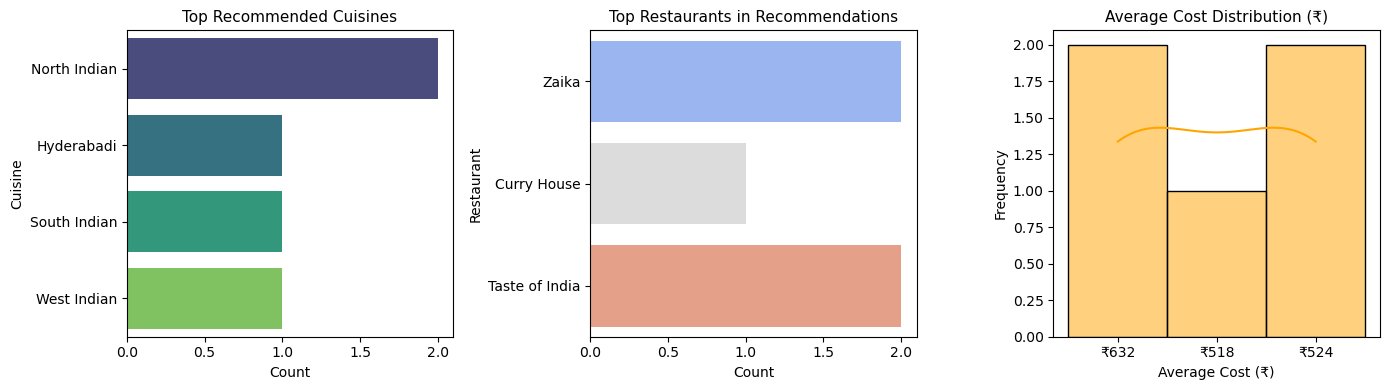

In [139]:
recommended_dishes = recommend_dishes("Paneer Tikka", "Bangalore")
visualize_recommendations(recommended_dishes)
